In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
from pathlib import Path

In [3]:
if "snakemake" not in globals():
    # For runs outside snakemake, simple mock_snakemake
    from types import SimpleNamespace
    folder = "summaries/230509-71a-fixasu/"

    member = {
        "input": {"statistics": folder+"statistics.csv"},
        "output": {"scenarios": [folder+f"cascade-{s}.pdf" for s in ["DE-71a-1H-H2u","DE-71a-1H-H2s","DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10","DE-71a-1H-H2s-wm-nH2t-mflex50-ramp5","DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt"]]},
    }
    snakemake = SimpleNamespace(**member)

In [4]:
# colors = {"wind available": "#0047AB",
        #   "wind used" : "#0000FF",
        #   "wind curtailed" : "#ADD8E6",
        #   "solar available": "#FFBF00",
        #   "solar used" : "#FFEA00",
        #   "solar curtailed" : "#FFFAA0",
        #   "battery charging" : "#696969",
        #   "battery discharging" : "#BEBEBE",
        #   "LDES charging" : "#c71585",
        #   "LDES discharging" : "#ff77ff",
        #   "direct supply" : "g",
        #  }

colors = {
    "wind available": "#56b4e9",
    "wind used" : "#5ebaff",
    "wind curtailed" : "#4182b2",
    "solar available": "#ece133",
    "solar used" : "#ece133",
    "solar curtailed" : "#9f9822",
    "battery charging" : "#0173b2",
    "battery discharging" : "#0173b2",
    "LDES charging" : "#cc78bc",
    "LDES discharging" : "#cc78bc",
    "direct supply" : "#029e73",
}

In [5]:
df = pd.read_csv(snakemake.input["statistics"],
                 index_col=0)
df = df.drop("status").astype(float)

In [6]:
df.columns

Index(['UK-71a-1H-H2s', 'UK-71a-1H-H2u', 'UK-71a-1H-H2s-wm-nH2t-mflex50-ramp5',
       'UK-71a-1H-H2s-wm-nH2t-mflex0-ramp10',
       'UK-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt', 'DE-71a-1H-H2s',
       'DE-71a-1H-H2u', 'DE-71a-1H-H2s-wm-nH2t-mflex50-ramp5',
       'DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10',
       'DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt', 'ES-71a-1H-H2s',
       'ES-71a-1H-H2u', 'ES-71a-1H-H2s-wm-nH2t-mflex50-ramp5',
       'ES-71a-1H-H2s-wm-nH2t-mflex0-ramp10',
       'ES-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt'],
      dtype='object')

In [7]:
df.index[df.index.str.contains("share")]

Index(['Allam share', 'CCGT share', 'air separation unit share',
       'battery_discharge share', 'battery_power share', 'dac share',
       'heat pump share', 'hydrogen_compressor share',
       'hydrogen_electrolyser share', 'hydrogen_turbine share', 'load share',
       'methanol synthesis share', 'solar share', 'wind share'],
      dtype='object')

In [8]:
scenario = "DE-71a-1H-H2u"
scenario = "DE-71a-1H-H2s"
scenario = 'DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10'
scenario = 'DE-71a-1H-H2s-wm-nH2t-mflex50-ramp5'
scenario = 'DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt'
s = df[scenario]
s

Allam cycle capacity                         NaN
Allam cycle capacity factor                  NaN
Allam cycle capex                            NaN
Allam cycle electricity capacity             NaN
Allam cycle mv                               NaN
                                        ...     
wind curtailment                    1.338466e+01
wind mv                             6.055485e+01
wind opex                           6.137068e+06
wind share                          4.930228e-01
wind totex                          1.858146e+09
Name: DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt, Length: 169, dtype: float64

In [9]:
s[s.index.str.contains("share")]

Allam share                             NaN
CCGT share                     7.280768e-02
air separation unit share      2.323658e-08
battery_discharge share        2.542966e-01
battery_power share            2.648922e-01
dac share                      8.427989e-03
heat pump share                1.672220e-02
hydrogen_compressor share      7.643652e-04
hydrogen_electrolyser share    2.030735e-01
hydrogen_turbine share                  NaN
load share                     1.000000e+00
methanol synthesis share       3.287859e-02
solar share                    7.066318e-01
wind share                     4.930228e-01
Name: DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt, dtype: float64

In [10]:
demand = 100

def build_tp(scenario):
    s = df[scenario]

    tp = pd.DataFrame(dtype=float)
    tp.at["available","wind available"] = s["mean available generation wind"]/demand
    tp.at["available","solar available"] = s["mean available generation solar"]/demand

    tp.at["used","wind used"] = s["mean generation wind"]/demand
    tp.at["used","solar used"] = s["mean generation solar"]/demand
    tp.at["used","wind curtailed"] = s["wind curtailment"]/demand
    tp.at["used","solar curtailed"] = s["solar curtailment"]/demand

    tp.at["demand","battery charging"] = s["battery_power share"]

    if "wm" in scenario:
        tp.at["demand","LDES charging"] = s["hydrogen_electrolyser share"] + s["hydrogen_compressor share"] + s["methanol synthesis share"] + s["dac share"] + s["heat pump share"] + s["air separation unit share"]
    else:
        tp.at["demand","LDES charging"] = s["hydrogen_electrolyser share"] + s["hydrogen_compressor share"]

    tp.at["demand","direct supply"] = tp.loc["used",["wind used","solar used"]].sum() - tp.loc["demand",["LDES charging","battery charging"]].sum()

    new_cols = pd.Index(["direct supply"]).append(tp.columns.drop("direct supply"))

    tp = tp[new_cols]

    tp.at["final","direct supply"] = tp.at["demand","direct supply"]
    tp.at["final","battery discharging"] = s["battery_discharge share"]

    if "ccgt" in scenario:
        tp.at["final","LDES discharging"] = s["CCGT share"]
    elif "wm" in scenario:
        tp.at["final","LDES discharging"] = s["Allam share"]
    else:
        tp.at["final","LDES discharging"] = s["hydrogen_turbine share"]

    return tp

In [11]:

def rename_scenario(name):
    name = name.replace("-3a","").replace("-71a","").replace("-10a","").replace("H2s-wm-nH2t","MeOH").replace("-1H","").replace("mflex50-ramp5","lowflex").replace("mflex0-ramp10","highflex")
    name = name.replace("highflex-ccgt","CCGT")
    #name = name.replace("-","\n")
    return name

def plot_fig(tp,scenario,output_file):

    fig, ax = plt.subplots()
    fig.set_size_inches((5,3))

    ax.axhline(y = 1, color = 'grey', alpha = 0.5, linestyle = '-')

    tp.fillna(0.).plot(kind="bar",stacked=True,color=colors,
                       ax=ax,
                       rot=0)

    if scenario[-3:] != "H2s":
        ax.set_ylim([0,1.7])

    #https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    legend = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    ax.plot([0.25,0.75],[tp.at["available","wind available"],tp.at["used","wind used"]],color="grey",alpha=0.5,linestyle="--")

    ax.plot([0.25,0.75],[tp.loc["available",["solar available","wind available"]].sum(),tp.loc["used",["solar used","wind used"]].sum()],color="grey",alpha=0.5,linestyle="--")

    ax.plot([1.25,1.75],[tp.loc["used",["solar used","wind used"]].sum(),tp.loc["used",["solar used","wind used"]].sum()],color="grey",alpha=0.5,linestyle="--")


    ax.plot([2.25,2.75],[tp.at["final","direct supply"],tp.at["final","direct supply"]],color="grey",alpha=0.5,linestyle="--")

    ax.plot([2.25,2.75],[tp.at["final","direct supply"]+tp.at["demand","battery charging"],tp.at["final","direct supply"]+tp.at["final","battery discharging"]],color="grey",alpha=0.5,linestyle="--")

    ax.plot([2.25,2.75],[tp.loc["demand"].sum(),tp.loc["final"].sum()],color="grey",alpha=0.5,linestyle="--")




    ax.set_title(rename_scenario(scenario))

    ax.set_ylabel("fraction of demand")

    fig.savefig(output_file,
                transparent=True,
                bbox_extra_artists=(legend,),
                bbox_inches='tight')

DE-71a-1H-H2u
DE-71a-1H-H2s
DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10
DE-71a-1H-H2s-wm-nH2t-mflex50-ramp5
DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt


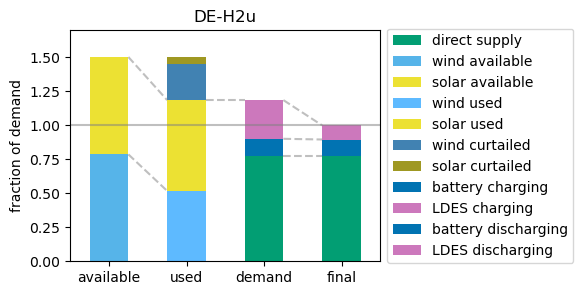

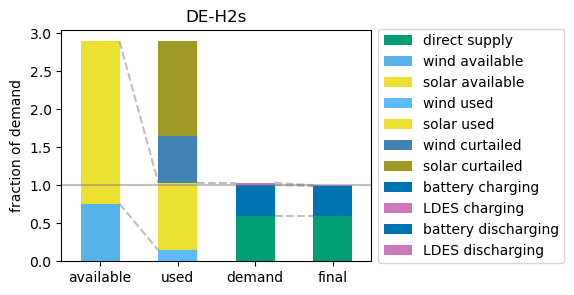

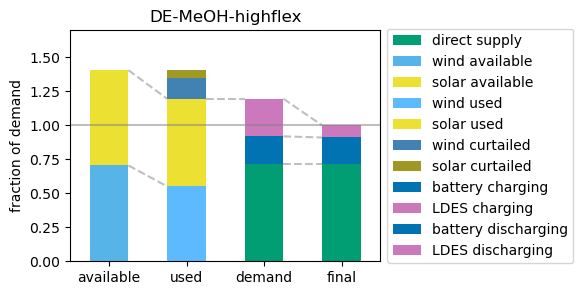

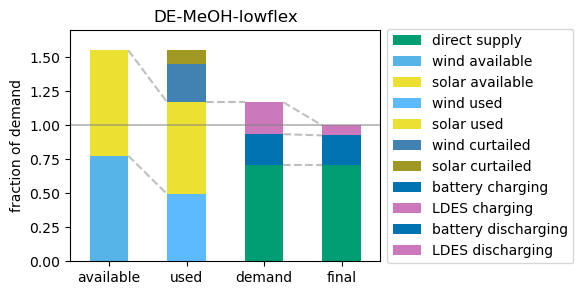

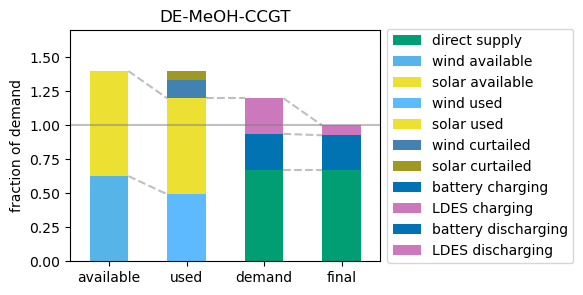

In [12]:

# for scenario in [
#     "DE-71a-1H-H2u",
#     "DE-71a-1H-H2s",
#     "DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10",
#     "DE-71a-1H-H2s-wm-nH2t-mflex50-ramp5",
#     "DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt",
#     ]:
for output_file in snakemake.output["scenarios"]:
    scenario = Path(output_file).stem.replace("cascade-","") # Extract scenario from filename with filenames being "cascade-<scenario>.pdf"
    print(scenario)
    tp = build_tp(scenario)
    plot_fig(tp, scenario, output_file)


In [13]:
tp.loc["final"]

direct supply          0.672896
wind available              NaN
solar available             NaN
wind used                   NaN
solar used                  NaN
wind curtailed              NaN
solar curtailed             NaN
battery charging            NaN
LDES charging               NaN
battery discharging    0.254297
LDES discharging       0.072808
Name: final, dtype: float64

In [14]:
snakemake.output

{'scenarios': ['summaries/230509-71a-fixasu/cascade-DE-71a-1H-H2u.pdf',
  'summaries/230509-71a-fixasu/cascade-DE-71a-1H-H2s.pdf',
  'summaries/230509-71a-fixasu/cascade-DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10.pdf',
  'summaries/230509-71a-fixasu/cascade-DE-71a-1H-H2s-wm-nH2t-mflex50-ramp5.pdf',
  'summaries/230509-71a-fixasu/cascade-DE-71a-1H-H2s-wm-nH2t-mflex0-ramp10-ccgt.pdf']}